## Definimos el modelo

La arquitectura se dividio en 2 redes neuronales:

Generador: Para el generador, se siguió la arquitectura propuesta en el paper de DCGan, capas convolucionales transpuestas seguidas de batchnorm y activador ReLU. Para la capa final se probaron 2 funciones de activación: Sigmoide y Tanh, sin embargo, la calidad de las imagenes generadas no era aceptable, por lo cual dejar la salida sin activación fue lo que mejor resultado nos entrega. Como las imagenes reales están normalizadas con valores entre 0 y 1, la salida del generador pasa por una normalización también.

Discriminador: Al igual que en el generador, se siguió como modelo la arquitectura propuesta en el paper DCGAN, capas convolucionales seguidas de batchnorm y activador LeakyReLU. Teniamos un problema al entrenar debido a que el discriminador se ajustaba muy rápido con respecto al generador, produciendo que la loss del generador subiera a lo largo del entrenamiento. La solución que encontramos fue suavizar la entrada del discriminador añadiendole ruido blanco gaussiano (link ref https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/), logrando así estabilidad en el entrenamiento.

In [1]:
import torch
import matplotlib.pyplot as plt
class GAN_Generator(torch.nn.Module):
    
    def __init__(self, convtrans_channel=[8,16,24,48,1], conv_channel=[1,3,6,1],z_dim=64,channel_input=1,bs=128,device='cuda'):
        
        super(type(self), self).__init__()
        self.z_dim=z_dim
        self.batch=bs
        self.channel=channel_input
        self.device=device
        
        self.generative_layers = torch.nn.Sequential(
                                  torch.nn.ConvTranspose2d(self.channel,convtrans_channel[0],5,stride=2,padding=1 ),
                                  torch.nn.BatchNorm2d(convtrans_channel[0]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[0],convtrans_channel[1],5,padding=1),
                                  torch.nn.BatchNorm2d(convtrans_channel[1]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[1],convtrans_channel[2],5,padding=1),
                                  torch.nn.BatchNorm2d(convtrans_channel[2]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[2],convtrans_channel[3],5,padding=2),
                                  torch.nn.BatchNorm2d(convtrans_channel[3]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[3],convtrans_channel[4],5,padding=2),
                                  #torch.nn.Sigmoid(),
                                 # torch.nn.Tanh(),
                                  
            
                                )
    

                
    
    def generador(self, z):
        z=z.view(-1,self.channel,8,8)
        x_falso=self.generative_layers(z)
        x_falso=self.normalize(x_falso)
        #print(x_falso.shape)
        return x_falso
            
    def sample(self,size):
        z=torch.randn(size,self.channel*self.z_dim , device=self.device)
        return z
    
    def normalize(self,x):
        im_min = x.min(dim=-1).values.min(dim=-1).values.reshape(-1, x.shape[1], 1, 1)
        im_max = x.max(dim=-1).values.max(dim=-1).values.reshape(-1, x.shape[1], 1, 1)
        x = (x - im_min)/(im_max-im_min)
        return x
       

class GAN_Discriminator(torch.nn.Module):
    
    def __init__(self, convtrans_channel=[6,3,1], conv_channel=[1,6,12,24,1],z_dim=100,channel_input=1,bs=128,device='cuda'):
        
        super(type(self), self).__init__()
        self.z_dim=z_dim
        self.batch=bs
        self.channel=channel_input
        self.device=device
        
        ##capas generadoras
        self.discriminator_layers= torch.nn.Sequential(
                                   torch.nn.Conv2d(conv_channel[0],conv_channel[1],5,stride=1,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[1]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[1],conv_channel[2],5,stride=2,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[2]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[2],conv_channel[3],5,stride=1,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[3]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[3],conv_channel[3],6,stride=2,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[3]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[3],conv_channel[4],4,stride=2,padding=1),
                                   torch.nn.Sigmoid(),                                
        
                                )

        
    def discriminador(self,supuesto_x):
        noise=torch.randn(supuesto_x.shape , device=self.device) ##agregando ruido blanco gaussiano para estabilizar entrenamiento
        supuesto_x= torch.clamp(supuesto_x + noise,0.01, 1.0) 
        supuesto_x=self.discriminator_layers(supuesto_x)
        supuesto_x=supuesto_x.view(-1)
        
        return supuesto_x
    
def loss_disc(disc_datos_xfalso,disc_datos_x,size):
    loss=(torch.log(disc_datos_x) + torch.log(1 - disc_datos_xfalso) ).sum() / size
    return -loss
    
def loss_gen(disc_datos_xfalso,size):
    loss=torch.log(disc_datos_xfalso).sum() / size
    return -loss

In [2]:
ls /opt/data-nas/HiTS

images_test.csv*  images_train.csv*  label_test.csv*  label_train.csv*


### cargamos el CSV de entrenamiento

In [3]:
import pandas as pd
import numpy as np
df=pd.read_csv("/opt/data-nas/HiTS/images_train.csv",header=None)
differences=np.array(df.iloc[:,0:21*21])
df=0  ##manera trucha de liberar memoria by javier rojas
df=pd.read_csv("/opt/data-nas/HiTS/label_train.csv",header=None)
labels=np.array(df)
df=0

### creamos dataloader

In [4]:
from torch.utils.data import TensorDataset, DataLoader, Subset 
batch_size=128
astro_image_tensor=torch.from_numpy(differences.astype('float32')).view(-1,1,21,21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 1, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 1, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

astro_dataset = TensorDataset(astro_image_tensor, torch.from_numpy(labels))

train_loader = DataLoader(astro_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

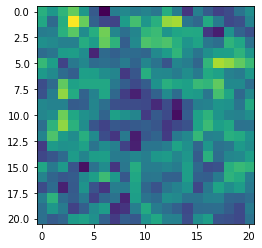

In [6]:

for image,label in train_loader:
    
    plt.imshow(image[0][0].detach())
    break

## Entrenamiento

In [ ]:
from tqdm import tqdm_notebook
n_epoch=500
k_disc=1
device='cuda'
GEN=GAN_Generator(bs=batch_size).cuda()
DISC=GAN_Discriminator(bs=batch_size).cuda()
optimizer_gen = torch.optim.Adam(GEN.parameters(), lr=0.0002)
optimizer_disc = torch.optim.Adam(DISC.parameters(), lr=0.0002)
den = train_loader.__len__()*train_loader.batch_size
criterion = torch.nn.BCELoss()
global_loss=np.inf
for epoch in tqdm_notebook(range(n_epoch)):
    for k in range(k_disc):
        train_disc_loss=0.0
        train_gen_loss=0.0
        for image,label in train_loader:
            optimizer_disc.zero_grad()  
            image=image.cuda()
            
            ##Train for real images
            output_real = DISC.discriminador(image)#.view(-1)
            label = torch.full((image.shape[0],), 1.0, dtype=torch.float, device=image.device)
            lossD_real=criterion(output_real,label)
            lossD_real.backward()
            ##Train disc fake image
            label.fill_(0)
            fake=GEN.generador(GEN.sample(image.shape[0]))
            output_fake_D = DISC.discriminador(fake.detach())#.view(-1)
            lossD_fake=criterion(output_fake_D,label)
            lossD_fake.backward()
            #lossD=loss_disc(output_fake_D,output_real,image.shape[0])
            #lossD.backward()
            total_loss=lossD_fake + lossD_real
            optimizer_disc.step()
            #train_disc_loss += lossD.item()
            train_disc_loss+=total_loss.item() /den
            
            ##Train generator
            optimizer_gen.zero_grad()  
            label.fill_(1) 
            output=DISC.discriminador(fake)#.view(-1)
            lossG=criterion(output,label)
            #lossG=loss_gen(output,image.shape[0])
            lossG.backward()
            #optimizer_disc.step()
            optimizer_gen.step()
            train_gen_loss+=lossG.item() / den
                               
                                 
            
            
    print("Train loss discriminador: %f  Train loss Generator :%f "%(train_disc_loss,train_gen_loss))



/home/admin/miniconda3/envs/PT/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Train loss discriminador: 0.010395  Train loss Generator :0.006085 
Train loss discriminador: 0.010502  Train loss Generator :0.005888 
Train loss discriminador: 0.010209  Train loss Generator :0.006050 
Train loss discriminador: 0.010429  Train loss Generator :0.005898 
Train loss discriminador: 0.010742  Train loss Generator :0.005603 
Train loss discriminador: 0.010827  Train loss Generator :0.005498 
Train loss discriminador: 0.010752  Train loss Generator :0.005559 
Train loss discriminador: 0.010786  Train loss Generator :0.005512 
Train loss discriminador: 0.010761  Train loss Generator :0.005531 
Train loss discriminador: 0.010744  Train loss Generator :0.005565 
Train loss discriminador: 0.010790  Train loss Generator :0.005492 
Train loss discriminador: 0.010761  Train loss Generator :0.005519 
Train loss discriminador: 0.010737  Train loss Generator :0.005531 
Train loss discriminador: 0.010762  Train loss Generator :0.005535 
Train loss discriminador: 0.010743  Train loss G

## Guardando los modelitos

In [ ]:
torch.save(GEN.state_dict(), '/opt/data-nas/Models_Javier/GEN_HITS_2.pt')
torch.save(DISC.state_dict(), '/opt/data-nas/Models_Javier/DISC_HITS_2.pt')

In [ ]:
!sudo poweroff

## Cargamos los modelitos

In [4]:
GEN=GAN_Generator(device='cpu')
DISC=GAN_Discriminator(device='cpu')
GEN.load_state_dict(torch.load("/opt/data-nas/Models_Javier/GEN_HITS.pt"))
DISC.load_state_dict(torch.load("/opt/data-nas/Models_Javier/DISC_HITS.pt"))

<All keys matched successfully>

#### Muestras desde red generativa

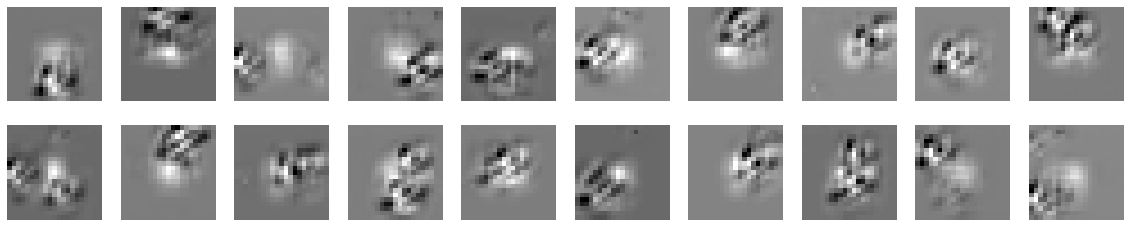

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(2):
    for j in range(10):
        ax[i,j].imshow(GEN.generador(GEN.sample(1))[0][0].cpu().detach().numpy(),cmap="gray")
        ax[i,j].axis('off')


Se aprecia que las imagenes generadas pareciera ser una interpolación entre basura y transiente. Además se nota que las imágenes generadas no son muy diferentes, creemos que el modelo se centró en generar imágenes de un tipo. 

## Tareas pendientes a futuro

* Entrenar por mas épocas, el dataset de HiTS es demasiado extenso y demora en entrenar, por lo cual hubiese sido ideal entrenarlo por al menos unas 200 épocas.

* Guardar el mejor modelo, como la GAN son 2 redes, quedó pendiente si guardar el mejor modelo para el generador y discriminador por separado dependiendo de su función de perdida o si guardar el mejor modelo solo si el generador disminuye. Actualmente solo guarda el ultimo modelo, que claramente no implica que sea el mejor